In [41]:
#importing the data 
from sklearn.datasets import make_circles

n_samples = 1000 

X , y = make_circles(n_samples , 
                     noise = 0.03 , #adding a little bit of noise of dots
                     random_state= 42) 

In [42]:
X[:5] , y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0], dtype=int64))

In [43]:
#making dataframe of the circle
import pandas as pd 
circles = pd.DataFrame(
    {'X1': X[: , 0]  , 
     'X2': X[: , 1] , 
     'label': y}
)
circles.sample(5)

,X1,X2,label
394,0.359177,0.693211,1
78,0.299599,0.772465,1
162,-0.197917,0.729937,1
827,-0.832136,0.487093,0
623,-0.532833,0.800326,0


In [44]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

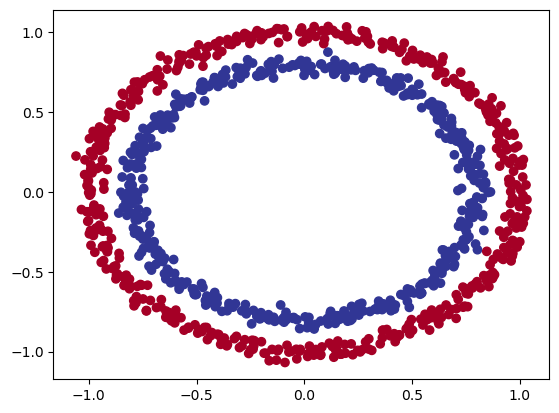

In [45]:
import matplotlib.pyplot as plt 
plt.scatter( x = circles['X1'] , 
            y = circles['X2'] , 
            c = y , 
            cmap = plt.cm.RdYlBu)


In [46]:
y[0].shape # <- this shows there is no shape at all

()

In [47]:
#so we turn the data into tensors 
import torch 
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)



X[:5] , y [:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [48]:
from sklearn.model_selection import train_test_split 

X_train , X_test  , y_train , y_test = train_test_split(X , 
                                                        y , 
                                                        test_size = 0.2 ,
                                                         random_state= 42 )
len(X_train) , len(X_test) , len(y_train) , len(y_test)

(800, 200, 800, 200)

In [49]:
#building the model 
# import torch 
from torch import nn 

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [50]:
class CircleModelv0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1  = nn.Linear(in_features=2 , out_features= 5) 
        self.layer_2 = nn.Linear(in_features=5 , out_features=1)

    #defining forward pass for forward propagation
    def forward(self , x):
        return self.layer_2(self.layer_1(x))
model0 = CircleModelv0()
model0.to(device)
model0

CircleModelv0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [51]:
#replicating CircleModelv0  with nn.Sequential 
model_0 = nn.Sequential(
    nn.Linear(in_features=2 , out_features=5), 
    nn.Linear(in_features=5 , out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [52]:
untrained_predictions = model0(X_test.to(device))
print(f"Length of predictions: {len(untrained_predictions)}, Shape: {untrained_predictions.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_predictions[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[ 0.0004],
        [-0.0377],
        [-0.0430],
        [ 0.0133],
        [-0.2707],
        [-0.2922],
        [-0.2191],
        [-0.2793],
        [-0.0333],
        [-0.0428]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [53]:
#setting up loss function and optimizer 

#loss function 
loss_fn = nn.BCEWithLogitsLoss()

#optimizer 
optimizer = torch.optim.SGD(params = model0.parameters() , 
                            lr = 0.01)

#creating an evaluation metric <- accuracy man 
def accuracy_fn(y_true , y_pred):
    correct = torch.eq(y_pred , y_true).sum().item()
    acc = (correct/len(y_pred)) * 100 
    return acc


#or we can import a function from sklearn 
from sklearn.metrics import accuracy_score


In [54]:
y_logits = model0(X_test.to(device))[:5]
y_logits

tensor([[ 0.0004],
        [-0.0377],
        [-0.0430],
        [ 0.0133],
        [-0.2707]], device='cuda:0', grad_fn=<SliceBackward0>)

In [55]:
#using sigmoid on model logits 

y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5001],
        [0.4906],
        [0.4893],
        [0.5033],
        [0.4327]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [56]:
y_preds = torch.round(y_pred_probs)
y_preds.squeeze() , y_test[:5]

(tensor([1., 0., 0., 1., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>),
 tensor([1., 0., 1., 0., 1.]))

In [57]:
#training and testing loop 

torch.manual_seed(42) #<- setting up the manual seed 

epochs = 100 

#sending the data to gpu
X_train , y_train = X_train.to(device) , y_train.to(device)
X_test , y_test = X_test.to(device) , y_test.to(device)

#train🚆 test🧪 loop
for epoch in range(epochs):
    #putting the model in training mode 

    model0.train()

    #Forward Pass (in raw logits)
    y_logits = model0(X_train).squeeze() 
    y_preds = torch.round(torch.sigmoid(y_logits)) # <- turing logits into probabilities

    loss = loss_fn(y_logits , y_train)
    acc = accuracy_fn(y_train , y_preds)

    #optimizer 
    optimizer.zero_grad()

    #back propagation
    loss.backward()

    #updating parameters of layers 
    optimizer.step()

    ##putting the model  in testing mode 
    model0.eval()
    with torch.inference_mode():
        test_logits = model0(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits , y_test)

        test_acc = accuracy_fn(test_preds , y_test)
    

    #priniting out the process 
    if epoch % 10 == 0 :
        print(f"Epoch {epoch} | Train Loss: {loss:.5f} , Accuracy: {acc:.5f}%  | Test Loss: {test_loss:.5f} , Test Accuracy: {test_acc:.5f}")


Epoch 0 | Train Loss: 0.69713 , Accuracy: 46.75000%  | Test Loss: 0.69714 , Test Accuracy: 44.00000
Epoch 10 | Train Loss: 0.69683 , Accuracy: 47.12500%  | Test Loss: 0.69685 , Test Accuracy: 43.50000
Epoch 20 | Train Loss: 0.69656 , Accuracy: 47.00000%  | Test Loss: 0.69658 , Test Accuracy: 44.50000
Epoch 30 | Train Loss: 0.69631 , Accuracy: 46.62500%  | Test Loss: 0.69634 , Test Accuracy: 46.00000
Epoch 40 | Train Loss: 0.69608 , Accuracy: 46.75000%  | Test Loss: 0.69611 , Test Accuracy: 45.50000
Epoch 50 | Train Loss: 0.69587 , Accuracy: 46.75000%  | Test Loss: 0.69590 , Test Accuracy: 46.00000
Epoch 60 | Train Loss: 0.69568 , Accuracy: 47.12500%  | Test Loss: 0.69571 , Test Accuracy: 45.50000


Epoch 70 | Train Loss: 0.69551 , Accuracy: 47.25000%  | Test Loss: 0.69554 , Test Accuracy: 46.00000
Epoch 80 | Train Loss: 0.69534 , Accuracy: 47.62500%  | Test Loss: 0.69538 , Test Accuracy: 46.00000
Epoch 90 | Train Loss: 0.69520 , Accuracy: 48.50000%  | Test Loss: 0.69523 , Test Accuracy: 46.50000


In [58]:
#lol what am I doing😵‍💫
#Oh I am downloading some modules to visualize the data

import requests 
from pathlib import Path 

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py" , "wb") as f:
        f.write(request.content)

helper_functions.py already exists, skipping download


In [59]:
from helper_functions import plot_predictions , plot_decision_boundary

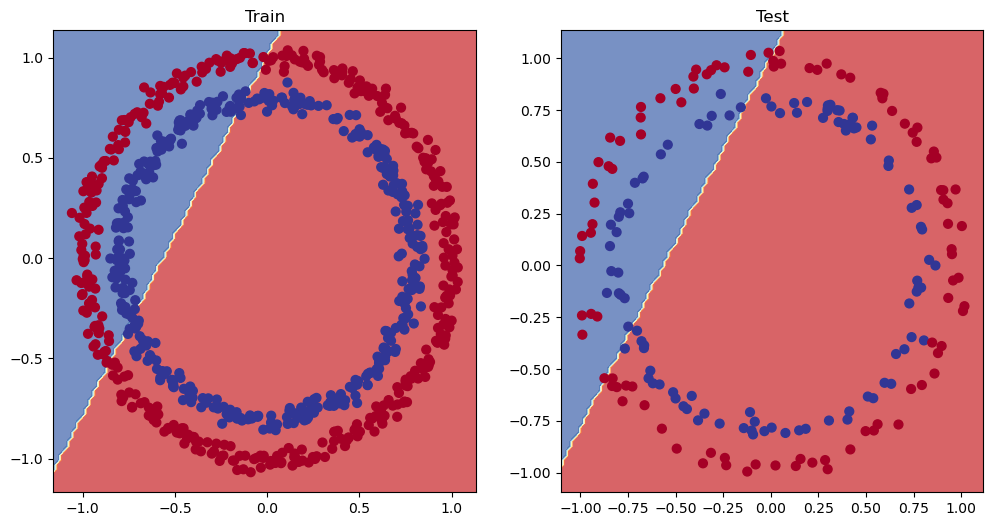

In [60]:
plt.figure(figsize=(12 , 6))
plt.subplot(1 , 2,1)
plt.title("Train")
plot_decision_boundary(model0 , X_train , y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model0 , X_test , y_test)

#The model is learning linear relationship whereas we need
non linear relationship.


In [133]:
#training the model with non-linear acivation function
#more layer and for more epoch 
class CircleModelv1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2 , out_features=8)
        self.layer_2 = nn.Linear(in_features=8 , out_features=10)
        self.layer_3 = nn.Linear(in_features = 10 , out_features = 4)
        self.layer_4 = nn.Linear(in_features=4 , out_features=1)
        self.relu = nn.LeakyReLU() # <- 💘 (activation function)

    def forward(self , x: torch.tensor) -> torch.tensor :
        return self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))
model1 =  CircleModelv1().to(device)
print(model1)

CircleModelv1(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=4, bias=True)
  (layer_4): Linear(in_features=4, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)


In [134]:
#setting up loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model1.parameters() , lr = 0.03)

In [135]:
#training the model 
epochs = 1000 

#sending the data to gpu
X_train , y_train = X_train.to(device) , y_train.to(device)
X_test , y_test = X_test.to(device) , y_test.to(device)

for epoch in range(epochs):

    #training the model
    model1.train()

    y_logits = model1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits , y_train)
    acc = accuracy_fn(y_preds , y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    #testing the model 
    model1.eval()
    with torch.inference_mode():
        test_logits  = model1(X_test).squeeze()
        test_preds  = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits , y_test)
        test_acc = accuracy_fn(y_test , test_preds)

    if epoch % 100 == 0 :
        print(f"Epoch {epoch} | Train Loss: {loss:.5f} , Accuracy: {acc:.5f}%  | Test Loss: {test_loss:.5f} , Test Accuracy: {test_acc:.5f}")



Epoch 0 | Train Loss: 0.69523 , Accuracy: 50.00000%  | Test Loss: 0.69495 , Test Accuracy: 50.00000
Epoch 100 | Train Loss: 0.69221 , Accuracy: 50.00000%  | Test Loss: 0.69200 , Test Accuracy: 50.00000
Epoch 200 | Train Loss: 0.69176 , Accuracy: 51.25000%  | Test Loss: 0.69156 , Test Accuracy: 52.50000
Epoch 300 | Train Loss: 0.69157 , Accuracy: 55.75000%  | Test Loss: 0.69135 , Test Accuracy: 55.50000
Epoch 400 | Train Loss: 0.69139 , Accuracy: 57.12500%  | Test Loss: 0.69115 , Test Accuracy: 55.50000
Epoch 500 | Train Loss: 0.69101 , Accuracy: 55.50000%  | Test Loss: 0.69083 , Test Accuracy: 53.00000
Epoch 600 | Train Loss: 0.69061 , Accuracy: 54.12500%  | Test Loss: 0.69053 , Test Accuracy: 52.50000
Epoch 700 | Train Loss: 0.69006 , Accuracy: 53.00000%  | Test Loss: 0.68987 , Test Accuracy: 53.50000
Epoch 800 | Train Loss: 0.68959 , Accuracy: 53.00000%  | Test Loss: 0.68942 , Test Accuracy: 53.50000
Epoch 900 | Train Loss: 0.68917 , Accuracy: 53.50000%  | Test Loss: 0.68901 , Test A

In [136]:
model1.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model1(X_test))).squeeze()
y_preds[:10] , y[:10]

(tensor([1., 0., 1., 1., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

In [137]:
accuracy_fn(y_preds ,y_test )

53.0

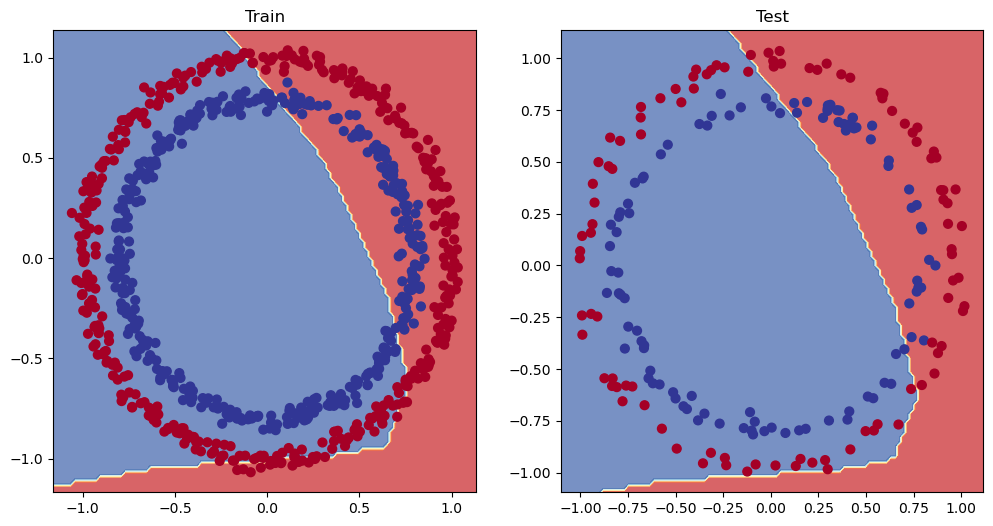

In [138]:
#plotting decision boundaries 
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model1 , X_train , y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model1 , X_test , y_test)